In [1]:
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from Gaussian_process_current import GaussianProcess, SparseGaussianProcess

ModuleNotFoundError: No module named 'Gaussian_process_tez'

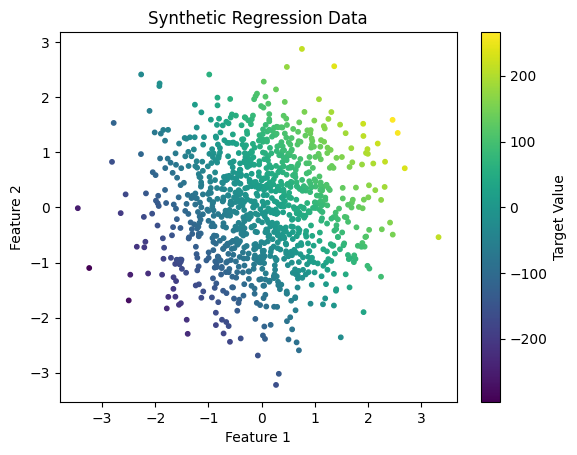

In [ ]:
# Generate synthetic regression dat
n_samples, n_features, noise = 1000, 2, 0.1
X, y = make_regression(n_samples=n_samples, n_features=n_features)

# Plot the first two dimensions of the data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=10)
plt.title('Synthetic Regression Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Target Value')
plt.show()


In [ ]:
def estimate_memory_usage(n_samples, n_features, model_type, n_inducing=None):
    # Memory for dataset (X_train and y_train)
    dataset_memory = n_samples * n_features * 8 + n_samples * 8  # X_train + y_train (float64, 8 bytes per float)
    if model_type == "GPR":
        # Full GP: Covariance matrix is N x N
        covariance_matrix_memory = n_samples ** 2 * 8  # N x N matrix, 8 bytes per float
    elif model_type == "SGPR":
        # Sparse GP: Covariance matrix is M x M (inducing points)
        if n_inducing is None:
            raise ValueError("n_inducing must be provided for SGPR")
        covariance_matrix_memory = n_inducing ** 2 * 8  # M x M matrix, 8 bytes per float
    
    # Memory for kernel parameters and gradients (assume around 1 KB for kernel + gradients)
    kernel_and_gradients_memory = 1024  # Rough estimation

    # Total memory usage estimate
    total_memory = dataset_memory + covariance_matrix_memory + kernel_and_gradients_memory

    return total_memory / (1024 ** 2)  # Convert to MB


In [ ]:
# Function to train a GP model and return the RMSE, average uncertainty, time taken, and iteration count
def train_and_evaluate_gp(n_samples, model, optim_method):
    # Generate synthetic regression data
    X, y = make_regression(n_samples=n_samples, n_features=1, noise=0.1, random_state=0)  # n_features=1 for plotting
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Create a GP regression model with an RBF kernel
    ''' if model == "GPR":
        model = gpf.models.GPR(data=(X_train, y_train), kernel=Kernel, mean_function=None)
    elif model == "SGPR":
        inducing_variables = tf.gather(X_train, tf.random.shuffle(tf.range(tf.shape(X_train)[0]))[:tf.shape(X_train)[0] // 10])
        model = gpf.models.SGPR(data=(X_train, y_train), kernel=Kernel, inducing_variable=inducing_variables, mean_function=None)
        gpf.config.set_default_jitter(1e-6) '''
    # Measure the time taken to optimize (which includes matrix inversion)
    start_time = time.time()
    
    # Optimize the model's parameters with a callback to count iterations
    if model == "GPR":
        model = GaussianProcess(X_train, y_train, optim_method)
    if model == "SGPR":
        n_inducing_points = int(len(X_train)*0.1)  # or any other number less than n_points
        Z_train = X_train[np.random.choice(len(X_train), n_inducing_points, replace=False)]
        model = SparseGaussianProcess(X_train, y_train,Z_train, optim_method)
    
    model.fit()
    
    
    end_time = time.time()
    
    # Time taken for matrix inversion and optimization
    time_taken = end_time - start_time
    
    # Retrieve and display parameter history if optimizer is ADAM
    if hasattr(model, "adam_optimizer"):
        param_history = model.adam_optimizer.param_history
        print("Parameter History:")
        #for params in param_history:
        #    print(params)
    
    # Make predictions on the test set
    means, variances = zip(*(model.predict(x.reshape(-1, 1)) for x in X_test))

    # Compute RMSE
    rmse = np.sqrt(np.mean((np.array(means) - y_test) ** 2))

    # Compute average uncertainty (standard deviation)
    avg_uncertainty = np.mean(np.sqrt(np.array(variances)))
    
    return rmse, avg_uncertainty, time_taken

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import psutil
import time

# Utility to get memory usage
def get_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Return memory usage in MB

# General function to run comparison for multiple GP models
def run_comparison(max_samples, models_kernels):
    start = 20
    step = 10
    dataset_sizes = np.arange(start, max_samples + 1, step)

    # Dictionary to store results for each model
    results = {
        'loss_history': {},
        'times': {},
        'uncertainties': {},
        'memory_usages': {},
    }

    # Loop over each model and its kernel
    for model_name, optim_method in models_kernels:
        loss_history = []
        times = []
        uncertainties = []  
        memory_usages = []
        


        for idx, size in enumerate(dataset_sizes):
            rmse, avg_uncertainty, time_taken = train_and_evaluate_gp(size, model_name, optim_method)
            loss_history.append(rmse)
            memory = estimate_memory_usage(n_samples=size, n_features=n_features, model_type=model_name, n_inducing=0.1*size)
            uncertainties.append(avg_uncertainty)
            times.append(time_taken)
            memory_usages.append(memory)
            name = model_name + " " + optim_method
            print(f"Model: {name}, Dataset size: {size}, Time: {time_taken:.4f} seconds, "
                  f"Memory: {memory:.2f} MB,"
                  f"Uncertainty: {avg_uncertainty:.4f}")
        
        # Store results for this model
        results['times'][name] = times
        results['uncertainties'][name] = uncertainties
        results['memory_usages'][name] = memory_usages
        results['loss_history'][name] = loss_history
    
    # Plotting the results
    plt.figure(figsize=(10, 12))
    # Loss plot

    plt.subplot(4, 1, 1)
    for name in results['loss_history']:
        plt.plot(dataset_sizes, results['loss_history'][name], 'o-', label=f'{name} Loss')
    plt.title('Performance Metrics vs Dataset Size')
    plt.ylabel('Loss (RMSE)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()
    
    # Time Plot
    plt.subplot(4, 1, 2)
    for name in results['times']:
        plt.plot(dataset_sizes, results['times'][name], 'o-', label=f'{name} Time')
    plt.title('Performance Metrics vs Dataset Size')
    plt.ylabel('Time (seconds)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    # Memory Usage Plot
    plt.subplot(4, 1, 3)
    for name in results['memory_usages']:
        plt.plot(dataset_sizes, results['memory_usages'][name], 'o-', label=f'{name} Memory Usage')
    plt.ylabel('Memory Usage (MB)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    # Uncertainty Plot
    plt.subplot(4, 1, 4)
    for name in results['uncertainties']:
        plt.plot(dataset_sizes, results['uncertainties'][name], 'o-', label=f'{name} Avg. Uncertainty')
    plt.ylabel('Uncertainty')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results

In [ ]:
models_kernels = [
    ("GPR", "L-BFGS-B"),
    ("SGPR", "L-BFGS-B"),
    ("GPR", "CG"),
    ("SGPR", "CG"),
    #("GPR", "ADAM"),
    #("SGPR", "ADAM"),
    

]
# Run the comparison for these models
run_comparison(max_samples=100, models_kernels=models_kernels)

Training complete. Optimal length scale: 1.05625, Signal variance: 0.58, Noise variance: 0.00
Model: GPR L-BFGS-B, Dataset size: 20, Time: 0.4321 seconds, Memory: 0.00 MB,Uncertainty: 0.0011
Training complete. Optimal length scale: 1.40344, Signal variance: 1.99, Noise variance: 0.00
Model: GPR L-BFGS-B, Dataset size: 30, Time: 1.0508 seconds, Memory: 0.01 MB,Uncertainty: 0.0026
Training complete. Optimal length scale: 0.76186, Signal variance: 1.91, Noise variance: 0.00
Model: GPR L-BFGS-B, Dataset size: 40, Time: 1.9918 seconds, Memory: 0.01 MB,Uncertainty: 0.0013
Training complete. Optimal length scale: 0.61952, Signal variance: 1.22, Noise variance: 0.00
Model: GPR L-BFGS-B, Dataset size: 50, Time: 2.9303 seconds, Memory: 0.02 MB,Uncertainty: 0.0009
Training complete. Optimal length scale: 0.96233, Signal variance: 1.80, Noise variance: 0.00
Model: GPR L-BFGS-B, Dataset size: 60, Time: 3.9842 seconds, Memory: 0.03 MB,Uncertainty: 0.0007
